# Water Quality
<img src="https://arcgis01.satapps.org/portal/sharing/rest/content/items/a499849ccd1f4c7fb0403b4c719f9dc1/resources/Water%20quality.png" />
[find out more](https://arcgis01.satapps.org/portal/apps/sites/?fromEdit=true#/data/pages/data-cube)
Product for calculation of Turbidity, via the Normalised Difference Turbidity Index (NDTI) in water bodies.




In [1]:
# jupyteronly
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
# generic python
import xarray as xr 
from shapely import wkt
from datetime import datetime
import numpy as np
import yaml
import rioxarray as rxr
import glob

# Import functions to load and stack data without datacube
from notebook_functions import *

import dask
import dask.array as da
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=4, memory_limit='7GB')

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33415/status,
Dashboard: http://127.0.0.1:33415/status,Workers: 2
Total threads: 8,Total memory: 13.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38511,Workers: 2
Dashboard: http://127.0.0.1:33415/status,Total threads: 8
Started: Just now,Total memory: 13.04 GiB
Comm: tcp://127.0.0.1:41895,Total threads: 4
Dashboard: http://127.0.0.1:41831/status,Memory: 6.52 GiB
Nanny: tcp://127.0.0.1:45131,


## Set Up Parameters

In [3]:
# Running locally on landsat 8 data for now
product = 'landsat_8'
allmeasurements = ["green","red","blue","nir","swir1","swir2", "pixel_qa"]

# St Maarten bounding box to subset the data
clip_coords = {'min_lon':-63.461424,
               'min_lat': 17.950000,
               'max_lon': -62.80000,
               'max_lat': 18.334848}

# Set size of dask chunks to use for the scenes
dask_chunks = dict(
    x = 1000,
    y = 1000
)

# Load Data

In [4]:
def prep_dataset(in_dir, measurement, product, clip_coords = None):
    """Prepare either the baseline or analysis dataset."""
    scenes = glob.glob(f'{in_dir}/*/')

    array_list = []

    for scene in scenes:
        yml = f'{scene}/datacube-metadata.yaml'
        with open (yml) as stream: yml_meta = yaml.safe_load(stream)

        # Load the bands provided in 'measurement' from the yaml file.
        o_bands_data = [ rxr.open_rasterio(scene + yml_meta['image']['bands'][b]['path'], chunks=dask_chunks) for b in measurement ] 

        # Clip the data to the bounding box if provided.
        if clip_coords is not None:
            o_bands_data = [ o_bands_data[i].rio.clip_box(minx = clip_coords['min_lon'], miny = clip_coords['min_lat'], 
                                                          maxx = clip_coords['max_lon'], maxy = clip_coords['max_lat']) 
                                                          for i in range(len(o_bands_data)) ]

        # Get the timestamp from the yaml file.
        timestamp = datetime.strptime(yml_meta['extent']['center_dt'], '%Y-%m-%d %H:%M:%S')

        # Stack the bands together into a single xarray dataset.
        band_data = stack_bands(o_bands_data, measurement, timestamp)

        # Append each stacked scene to a list to be combined later.
        array_list.append(band_data)

    # Stack the scenes together into xarray dataset.
    ds = stack_scenes(array_list)

    # Mask out nodata values.
    ds = ds.where(ds != -9999)
    print(f'Final Dataset: {ds}')

    return ds

In [5]:
# Running on data from St Maarten
dir = '/home/spatialdays/Documents/ARD_Data/StMaarten_Landsat/'
ds = prep_dataset(dir, allmeasurements, product, clip_coords)

## Run data for Tile7572 
# dir = '/home/spatialdays/Documents/testing-wofs/test_masking/Tile7572/BaselineData/'
# ds = prep_dataset(dir, allmeasurements, product)

Final Dataset: <xarray.Dataset>
Dimensions:      (time: 7, y: 1429, x: 2455)
Coordinates:
    spatial_ref  int64 0
  * x            (x) float64 -63.46 -63.46 -63.46 -63.46 ... -62.8 -62.8 -62.8
  * y            (y) float64 18.33 18.33 18.33 18.33 ... 17.95 17.95 17.95 17.95
  * time         (time) datetime64[ns] 2018-09-06 2022-11-20 ... 2018-03-14
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir1        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    swir2        (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    pixel_qa     (time, y, x) float64 dask.array<chunksize=(1, 1000, 1000),

## Cloud and Water Masking
Get just the areas of water from the image.

In [6]:
water_mask = ls_clean_mask(ds, keep_water=True)

## Create Parameter (NDTI) Composites

In [7]:
#From datacube utilities: 
def NDTI(dataset):
    NDTI = (dataset.red - dataset.green)/(dataset.red + dataset.green)
    NDTI = NDTI.where(dataset.red.notnull() & dataset.green.notnull())
    return NDTI

def _tsmi(dataset):
    return (dataset.red.astype('float64') + dataset.green.astype('float64')) * 0.0001 / 2


def tsm(dataset_in, clean_mask=None, no_data=0):
    """
    Inputs:
        dataset_in (xarray.Dataset) - dataset retrieved from the Data Cube.
    Optional Inputs:
        clean_mask (numpy.ndarray with dtype boolean) - true for values user considers clean;
            if user does not provide a clean mask, all values will be considered clean
        no_data (int/float) - no data pixel value; default: -9999
    Throws:
        ValueError - if dataset_in is an empty xarray.Dataset.
    """
    assert 'red' in dataset_in and 'green' in dataset_in, "Red and Green bands are required for the TSM analysis."
    # Default to masking nothing.
    #if clean_mask is None:
        #clean_mask = create_default_clean_mask(dataset_in)

    tsm = 3983 * _tsmi(dataset_in)**1.6246
    tsm.values[np.invert(clean_mask)] = no_data  # Contains data for clear pixels

    # Create xarray of data
    _coords = { key:dataset_in[key] for key in dataset_in.dims.keys()}
    dataset_out = xr.Dataset({'tsm': tsm}, coords=_coords)
    return dataset_out

In [10]:
mosaic_type = 'median'
index = 'NDTI'

# # Select and run the index calculation
# if index in ["TSM"]:
#     #tsm_dataset = xr.map_blocks(tsm, ds_clear)
#     tsm_dataset = tsm(ds, clean_mask=water_mask)
#     tsm_dataset = tsm_dataset.tsm
# elif index in ['NDTI']:
#     ds_clear = ds.where(water_mask == True)
#     tsm_dataset = NDTI(ds_clear)
# else:
#     print('invalid index')

# # Select and run the mosaic type
# if mosaic_type in ['mean']:
#     wq_mosaic = tsm_dataset.mean(dim=['time'])
# elif mosaic_type in ['max']:
#     wq_mosaic = tsm_dataset.max(dim=['time'])
# elif mosaic_type in ['min']:
#     wq_mosaic = tsm_dataset.min(dim=['time'])
# elif mosaic_type in ['median']:
#     wq_mosaic = tsm_dataset.median(dim=['time'])
# else:
#     print('invalid mosaic')


ds_clear = ds.where(water_mask == True)
composite_ds = ds_clear.median(dim='time')
tsm_dataset = NDTI(composite_ds)



### Visualize Water Quality Composites

/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/dask/utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spatialdays/anaconda3/envs/notebooks/lib/python3.11/site-packages/dask/utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


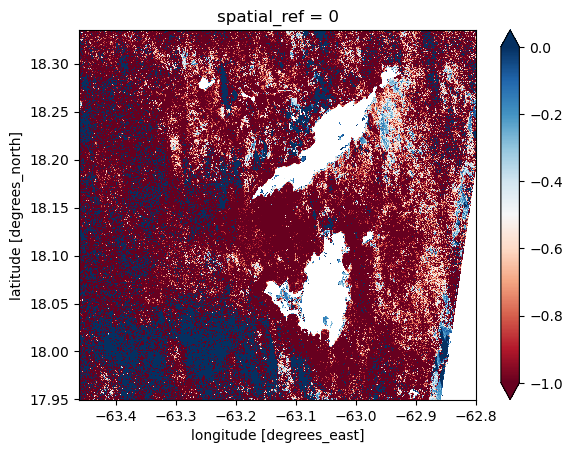

In [11]:
tsm_dataset.plot.imshow(cmap='RdBu', vmin=-1, vmax=0)

## Export Desired Data

In [12]:
tsm_dataset.rio.to_raster(f"StMaarten_WQMosaic.tif", dtype="float32", driver='COG')

wq_mosaic.plot.imshow(cmap="RdYlGn", vmin=-1, vmax=1, figsize=(10, 10))